# Spot detection for RNA imaging, part II: quantifying gene expression

Neubias course. May 14 th and may 15 th 2025. Pasteur Institute. 

Teacher: Jacques Bourg    
Helper:  Gaëlle Letort

We are going in this part to cover the basic steps of quantifying gene expression using fluorescence in situ hybridisation (FISH imaging). 

Although this notebook is a follow up from the previous part, there is no need to have done it.

# Introduction 

Quantifying gene expression using FISH is vital as it provides spatial resolution, showing expression levels in individual cells and their location within tissue architecture. This reveals cell-to-cell heterogeneity and localization missed by bulk measurements.

Biological questions answered include: Which specific cell types express a gene? How does expression vary across different tissue regions? What is the extent of cell-to-cell variability in expression? How does spatial context influence gene activity?

In [199]:
import napari
import numpy as np
import pandas
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.segmentation import expand_labels

from bigfish.classification import prepare_extracted_data, features_dispersion, compute_features

from detect_spots import DetectionPipeline
dt = DetectionPipeline()

from thresh_big_fish import SpotsThresholding
from cleaning import Cleaning
from quantify import Quantify

cl = Cleaning()
qf = Quantify()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
im = io.imread('D.tif')
viewer = napari.Viewer()
viewer.add_image(im); 

In [45]:
# split the channels in two : DAPI and FISH. Save as two separated files.
im_dapi  = im[...,0]
im_gene1 = im[...,1]
im_gene2 = im[...,2]

io.imsave( "dapi_image_2d.tif", im_dapi)
io.imsave( "fish_image_g1_2d.tif", im_gene1)
io.imsave( "fish_image_g2_2d.tif", im_gene2)

/home/jacques/miniconda3/envs/spot_course_env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: dapi_image_2d.tif is a low contrast image
  return func(*args, **kwargs)
/home/jacques/miniconda3/envs/spot_course_env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: fish_image_g1_2d.tif is a low contrast image
  return func(*args, **kwargs)
/home/jacques/miniconda3/envs/spot_course_env/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: fish_image_g2_2d.tif is a low contrast image
  return func(*args, **kwargs)


Load a Cellpose generated segmentation (unperfect but good enough for our purposes).

In [173]:
mask =  np.load('dapi_image_2d_seg.npy', allow_pickle=True)[()]
masks = mask['masks']

value_max = np.percentile(im_dapi, 99.9)
viewer = napari.Viewer()
viewer.add_image(im_gene1, rgb=False, name=f" gene1 ", opacity=0.8);
viewer.add_image(im_gene2, rgb=False, name=f" gene2 ", opacity=0.8);
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks,   name=f" segmentation");

Determine the region in which we will acount for the rna expression:

In [55]:
mask_bin = masks.copy()
mask_bin[mask_bin > 0] = 1

d = 50 # pixels

area_fish = expand_labels(mask_bin, distance=d)

viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(mask_bin, name=f" binary mask of segmented cells", opacity=0.5);
viewer.add_labels(area_fish, name=f" fish expression area", opacity=0.5);


Cleaning the rois: retain only the nuclei with a big area 

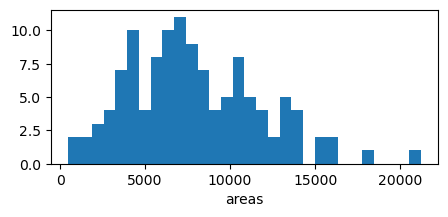

In [68]:
background_value = 0
labels, counts   = np.unique(masks, return_counts=True)

fig, ax = plt.subplots(figsize=(5,2))
ax.hist(counts[1:],bins= 30);
ax.set_xlabel('areas');

In [79]:
threshold = 5000 # try a threshold, observe the effect on the masks

labels_to_keep   = set(labels[counts >= threshold])   
if background_value in labels:
    labels_to_keep.add(background_value)

masks_clean = np.zeros(np.shape(masks), dtype=masks.dtype)
for label in labels_to_keep:
    masks_clean[masks == label] = label
        
value_max = np.percentile(im_dapi, 99.9)
viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks,   name=f" segmentation");    
viewer.add_labels(masks_clean,   name=f" cleaned segmentation");    

spot detection: gene 1 and 2

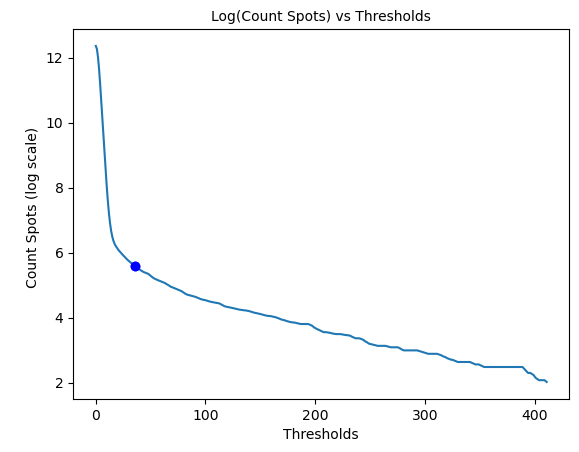

In [81]:
st_g1 = SpotsThresholding(BATCH=[Path('./fish_image_g1_2d.tif')], subtract_fish=False, voxel_size_nm=(112, 112), object_radius_nm=(150, 150)) # to get the Voxel size, I opened the D file in fiji and clicked on image/show Info.   
st_g1.run();

In [ ]:
spots_bf_g1 = st_g1.detected_spots['fish_image_g1_2d']

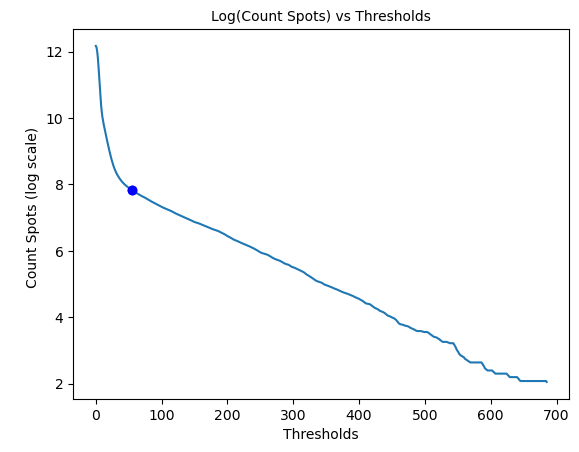

In [84]:
st_g2 = SpotsThresholding(BATCH=[Path('./fish_image_g2_2d.tif')], subtract_fish=False, voxel_size_nm=(112, 112), object_radius_nm=(150, 150)) # to get the Voxel size, I opened the "D.tif" file in fiji and clicked on image/show Info.   
st_g2.run(); 

In [85]:
spots_bf_g2 = st_g2.detected_spots['fish_image_g2_2d']

#### Clean the spots

a) Spots in the FISH expression area

In [ ]:
spots_clean_g1, _ = cl.subsel_points_in_mask_fish(spots_bf_g1, area_fish)
spots_clean_g2, _ = cl.subsel_points_in_mask_fish(spots_bf_g2, area_fish)


In [208]:
value_max = np.percentile(im_dapi, 99.9) 
viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks_clean,   name=f" cleaned segmentation"); 
viewer.add_labels(area_fish, name=f" fish expression area", opacity=0.5);
viewer.add_points(spots_bf_g1,   name=f" g1 raw spots",  size=2, face_color='green' ); 
viewer.add_points(spots_clean_g1,   name=f" g1 cleaned spots",  size=5, face_color=[0, 0, 0, 0], border_color= "#006400"); 
viewer.add_points(spots_bf_g2,   name=f" g2 raw spots",  size=2, face_color='red' ); 
viewer.add_points(spots_clean_g2,   name=f" g2 cleaned spots",  size=5, face_color=[0, 0, 0, 0], border_color= "#8B0000"); 

# Quantification

a) Spot intensity. Why does it makes sense to quantify spot intensity ? Assuming the spatial expression is very sparse what would it be the reason to get variability in the spot intensity ? 

In [101]:
g1_int, g2_int = [], []     # measure the intensity of the spots in the corresponding images:
 
for pos in spots_clean_g1:
    g1_int.append(im_gene1[pos[0], pos[1]])

for pos in spots_clean_g2:
    g2_int.append(im_gene2[pos[0], pos[1]])

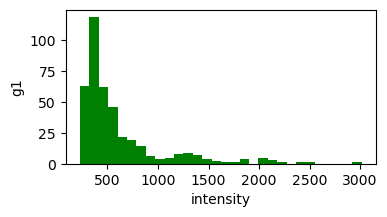

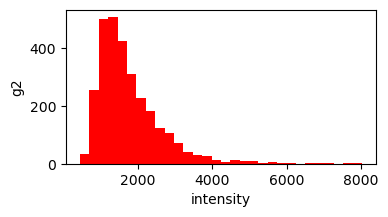

In [108]:
fig, ax = plt.subplots(figsize=(4,2))
ax.hist(g1_int, bins = 30, color='green');
ax.set_xlabel('intensity');
ax.set_ylabel('g1');

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(g2_int, bins = 30, color='red');
ax.set_xlabel('intensity');
ax.set_ylabel('g2');

Another way to measure gene expression is to quantify the spots width and sum the pixels in the estimated disk. 

1 - Biologically, why would one do this ? 

2- In the literature, people fit a gaussian to each spot and estimate the half width of the gaussian.
What is the problem with taking the half width ? Do you have a better idea to estimate the spots width ? 

b) Count matrix : count the spots/nuclei

In [150]:
area_bin_masks_clean = np.zeros_like(masks_clean)
area_bin_masks_clean[masks_clean >0] = 1

spots_clean_nuc_g1, _ = cl.subsel_points_in_mask_fish(spots_clean_g1, area_bin_masks_clean)
spots_clean_nuc_g2, _ = cl.subsel_points_in_mask_fish(spots_clean_g2, area_bin_masks_clean)

In [142]:
df_count_mat_g1  = qf.count_matrix(masks_clean, spots_clean_nuc_g1)
df_count_mat_g1

,spot_count
cell_id,
1,3
3,2
4,2
5,1
6,7
...,...
115,0
116,4
117,6


In [ ]:
df_count_mat_g2 = qf.count_matrix(masks_clean, spots_clean_nuc_g2)
df_count_mat_g2

,spot_count
cell_id,
1,8
3,50
4,12
5,7
6,35
...,...
115,16
116,41
117,18


Check visually that we counted correctly the number of rna's by putting your mouse on the top nuclei.   
In napari the label L (in this case the nuclei id) can be seen at the bottom left of the window  [x,y]: L. 

In [209]:
value_max = np.percentile(im_dapi, 99.9)      # you can leave this napari window open
viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks_clean, name=f" cleaned segmentation", opacity=0.5);
viewer.add_points(spots_clean_nuc_g1,   name=f" g1 cleaned spots in nuclei",  size=5, face_color='green'); 
viewer.add_points(spots_clean_nuc_g2,   name=f" g2 cleaned spots in nuclei",  size=5, face_color='red'); 

Text(0, 0.5, 'gene 2')

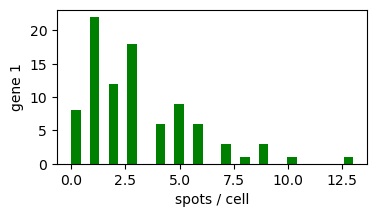

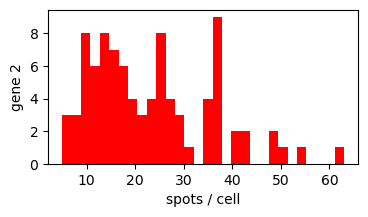

In [149]:
fig, ax = plt.subplots(figsize=(4,2))
ax.hist(df_count_mat_g1['spot_count'].values, bins =30, color = 'green')
ax.set_xlabel('spots / cell')
ax.set_ylabel('gene 1')

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(df_count_mat_g2['spot_count'].values, bins = 30, color = 'red')
ax.set_xlabel('spots / cell')
ax.set_ylabel('gene 2')

c) Subcellular/ subnuclear location

In Stueland et al.[2019], there are different indexes to characterize RNA distribution. 

Stueland, M., Wang, T., Park, H.Y. et al. RDI Calculator: An Analysis Tool to Assess RNA Distributions in Cells. Sci Rep 9, 8267 (2019). https://doi.org/10.1038/s41598-019-44783-2

Applying these indexes, the authors of the following paper revealed widespread co-translational RNA targeting to various cytoplasmic locations and identified specialized translation factories that compartmentalize translation and regulate nascent protein metabolism.

Chouaib, R., Safieddine, A., Pichon, X., Imbert, A., Kwon, O. S., Samacoits, A., Traboulsi, A. M., Robert, M. C., Tsanov, N., Coleno, E., et al. (2020). A dual protein–mRNA localization screen reveals compartmentalized translation and widespread co-translational RNA targeting. Developmental Cell, 54(6), 773–791.e5. https://doi.org/10.1016/j.devcel.2020.07.010


<div style="text-align: center;">
  <img src="subcellular_location.png" alt="FISH imaging" width="706" height="439">
</div>

The polarization index (PI) and the dispersion index µ2 are computed as:

 
<div style="text-align: left;">
  <img src="PI.png" alt=" " width="332" height="75" style="display: inline-block; margin-right: 5px; vertical-align: middle;">
  <img src="DI.png" alt=" " width="176" height="75" style="display: inline-block; vertical-align: middle;">
</div>


Rg being the radius of gyration of the cell. 
r is the distance of the pixel (i,j) to the centroid of the RNA signal and I is the intensity value of pixel (i,j)
in the two dimensional image. 

The Peripheral Distribution Index (PDI) is calculated similar to the dispersion index, but in this case the sec-
ond moment of RNA pixel intensity positions is calculated relative to the centroid of the nucleus


These indexes are implemented in bigfish.

In [ ]:
lab_n  = 107                              # Choose a nuclei in napari and note its label
mask_c = np.zeros_like(masks_clean)
mask_c[masks_clean == lab_n] = 1

spot_nuclei_n, _ = cl.subsel_points_in_mask_fish(spots_clean_nuc_g1, mask_c)

print(len(spot_nuclei_n))                 # verify that the number of points is the same as in napari

10


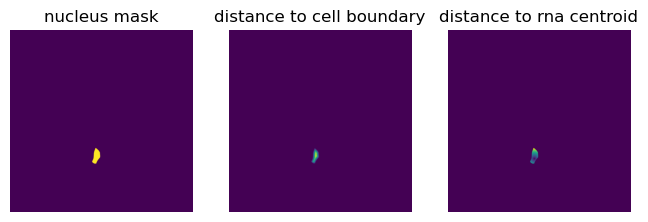

In [201]:
temp = prepare_extracted_data(mask_c, rna_coord=spot_nuclei_n, ndim= 2)
(cell_mask, 
distance_cell,
distance_cell_normalized,
centroid_cell,
distance_centroid_cell,
_,
cell_mask_out_nuc,
distance_nuc,
distance_nuc_normalized,
centroid_nuc,
distance_centroid_nuc,
_,
centroid_rna,
distance_centroid_rna,
centroid_rna_out_nuc,
distance_centroid_rna_out_nuc,
_) = temp


fig, ax = plt.subplots(1,3,figsize=(8,3))
ax[0].imshow(cell_mask); ax[0].set_axis_off(); ax[0].set_title('nucleus mask');
ax[1].imshow(distance_cell); ax[1].set_axis_off(); ax[1].set_title('distance to cell boundary');
ax[2].imshow(distance_centroid_rna); ax[2].set_axis_off(); ax[2].set_title('distance to rna centroid');

In [204]:
ndim = 2

#index_polarization, index_dispersion, index_peripheral_distribution = features_dispersion(im_gene1, spot_nuclei_n, centroid_rna, cell_mask, centroid_cell, centroid_nuc, ndim, check_input=False)

features, features_names = compute_features(
    cell_mask, nuc_mask, ndim, rna_coord=spot_nuclei_n,
    smfish=im_gene1, voxel_size_yx=112,
    foci_coord=None,
    centrosome_coord=None,
    compute_distance=True,
    compute_intranuclear=False,
    compute_protrusion=True,
    compute_dispersion=True,
    compute_topography=True,
    compute_foci=True,
    compute_area=True,
    return_names=True)




TypeError: 'NoneType' object is not subscriptable

d) Colocalization 

When we do the experiment with two or more genes, we can study their colocalization, which means to what extent two genes are expressed together in a given spatial scale. 

In [212]:
value_max = np.percentile(im_dapi, 99.9)      # you can leave this napari window open
viewer = napari.Viewer()
viewer.add_image(im_dapi, rgb=False, name=f" dapi", contrast_limits=(0, value_max), opacity=0.5);
viewer.add_labels(masks_clean, name=f" cleaned segmentation", opacity=0.5);
viewer.add_points(spots_clean_nuc_g1,   name=f" g1 cleaned spots in nuclei",  size=5, face_color='green'); 
viewer.add_points(spots_clean_nuc_g2,   name=f" g2 cleaned spots in nuclei",  size=5, face_color='red'); 

In [ ]:
df_bin_coloc = qf.bin_colocalization(masks_clean, spots_clean_nuc_g1, spots_clean_nuc_g2)
df_bin_coloc 

,cell_id,bin_coloc
0,1,True
1,3,True
2,4,True
3,5,True
4,6,True
...,...,...
85,115,False
86,116,True
87,117,True
88,118,True


In [241]:
df_bin_coloc[df_bin_coloc['cell_id']==106]   # verify manually that the algorithm output coherent results

,cell_id,bin_coloc
78,106,False


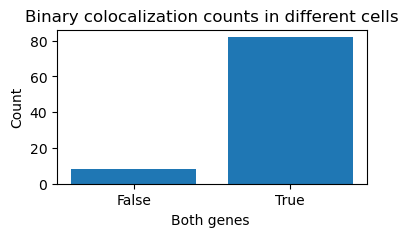

In [248]:
count_ones  = np.sum(df_bin_coloc['bin_coloc'].values*1 == 1)
count_zeros = np.sum(df_bin_coloc['bin_coloc'].values*1 == 0)

fig, ax = plt.subplots(figsize=(4, 2))
ax.bar([0, 1], [count_zeros, count_ones], tick_label=['False', 'True'])
ax.set_xlabel('Both genes ')
ax.set_ylabel('Count')
ax.set_title('Binary colocalization counts in different cells')
plt.show()